# Jupyter Notebook Detailing the Redundant Simulation Analysis Memo Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy.signal import medfilt2d

from matplotlib.colors import SymLogNorm
import numpy.ma as ma
import glob
import math

In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')


In [5]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))
    
print bases


[(0, 0), (0, 1), (0, 2), (0, 11), (0, 12), (0, 13), (0, 14), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 98), (0, 120), (0, 121), (0, 122), (0, 123), (0, 124), (0, 141), (0, 142), (0, 143), (1, 1), (1, 2), (1, 11), (1, 12), (1, 13), (1, 14), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 98), (1, 120), (1, 121), (1, 122), (1, 123), (1, 124), (1, 141), (1, 142), (1, 143), (2, 2), (2, 11), (2, 12), (2, 13), (2, 14), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 50),

In [6]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)
        
    
print nonreds


[(0, 0), (0, 98), (0, 143), (1, 1), (1, 98), (2, 2), (2, 98), (2, 120), (2, 141), (11, 11), (12, 12), (13, 13), (13, 98), (14, 14), (14, 98), (14, 120), (23, 23), (24, 24), (25, 25), (26, 26), (26, 98), (27, 27), (27, 98), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (40, 98), (41, 41), (41, 98), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (55, 98), (65, 65), (65, 124), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (71, 98), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (87, 98), (88, 88), (88, 98), (98, 98), (98, 124), (98, 143), (120, 120), (121, 121), (122, 122), (123, 123), (124, 124), (141, 141), (142, 142), (143, 143)]


In [7]:
v = deepcopy (uv)

In [8]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j


In [33]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.array(np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau),dtype = complex)
    
    temp[:,:,0] = np.fft.fftn(temp[:,:,0])
    
    temp[:,:,1] = np.fft.fftn(temp[:,:,1])
    
    temp[:,:,2] = np.fft.fftn(temp[:,:,2])
    
    temp[:,:,3] = np.fft.fftn(temp[:,:,3])
    
    return temp


In [34]:

def noise(amp,width):
    
    real = np.random.normal(amp,width,(60,1024,4))
    
    imag = np.random.normal(amp,width,(60,1024,4))
    
    result = np.array(real,dtype = complex)
    
    result.imag = imag
    
    return result


# Perfectly Redundant Simulation

In [35]:

new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

s_width = 1

s_amp = 0

i_width = 0

i_amp = 0

n_width = 0

n_amp = 0

for i in reds:
        
    sig = signal(s_amp,s_width,i[0])
    
    print 'working'
        
    for j in i:
        
        i_sig = signal(i_amp,i_width,j)
            
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2)
            
        ratio = np.sqrt(norm_power/new_power)
            
        sigs = (sig + i_sig) * ratio
            
        indices = v.antpair2ind(j[0],j[1])
            
        noi = noise(n_amp,n_width)
        
        visibility = sigs + noi
            
        new_data_array[indices,0,:,:] = visibility
            

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [36]:

for i in nonreds:
    
    print 'working'
    
    sig = signal(s_amp,s_width,i)
    
    i_sig = signal(i_amp,i_width,i)
    
    indices = v.antpair2ind(i[0],i[1])
            
    noi = noise(n_amp,n_width)
        
    norm_power = float(s_width**2)
            
    new_power = float(norm_power + i_width**2)
            
    ratio = np.sqrt(norm_power/new_power)        
        
    sigs = (sig + i_sig) * ratio
            
    visibility = sigs + noi
            
    new_data_array[indices,0,:,:] = visibility
    

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [37]:

print new_data_array


[[[[ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
   [ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
   [ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
   ..., 
   [ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
   [ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
   [ 0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
     0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]]]


 [[[-0.57018393 +0.00000000e+00j -1.38151100 +0.00000000e+00j
    -0.89882330 +0.00000000e+00j  0.45517447 +0.00000000e+00j]
   [-2.41535528 -1.95660074e-01j -3.27989928 +1.40594820e-01j
    -2.03805195 -8.50878697e-02j -1.34549288 +1.83

In [38]:
v.data_array = new_data_array

## Short Baselines

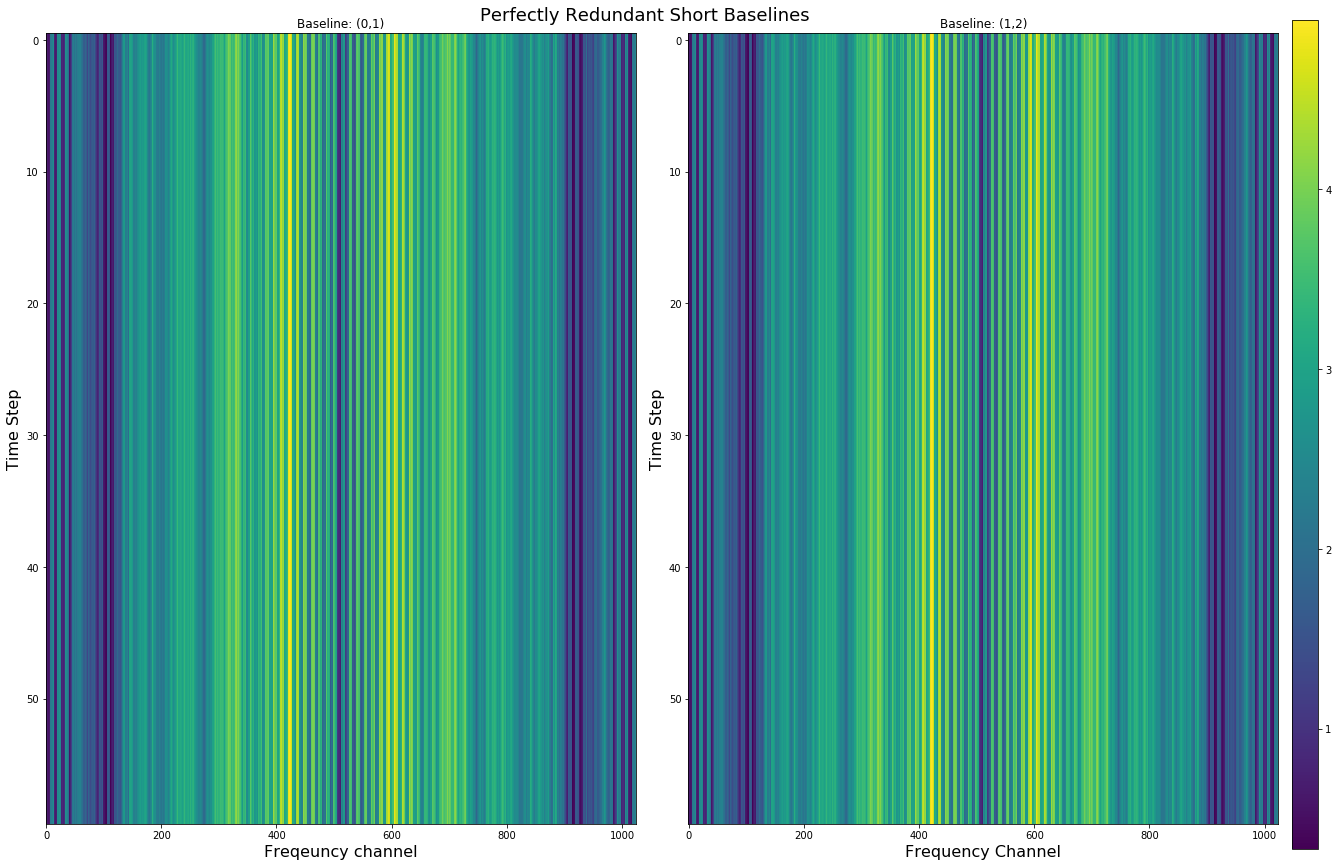

In [39]:

fig, axarr = plt.subplots(1,2, figsize=(18, 12))
plt.suptitle('Perfectly Redundant Short Baselines', y=1, fontsize=18)

axarr[0].set_title('Baseline: (0,1)')
axarr[0].set_ylabel('Time Step', fontsize=16)
axarr[0].set_xlabel('Freqeuncy channel', fontsize=16)
axarr[0].imshow(np.abs(v.get_data(0,1,'xx')),aspect='auto')

axarr[1].set_title('Baseline: (1,2)')
axarr[1].set_ylabel('Time Step', fontsize=16)
axarr[1].set_xlabel('Frequency Channel', fontsize=16)
im=axarr[1].imshow(np.abs(v.get_data(1,2,'xx')),aspect='auto')

cb_ax = fig.add_axes([1, .025, 0.02, .96])
cbar = fig.colorbar(im, cax=cb_ax)

plt.tight_layout()
plt.show()


## Long Baselines

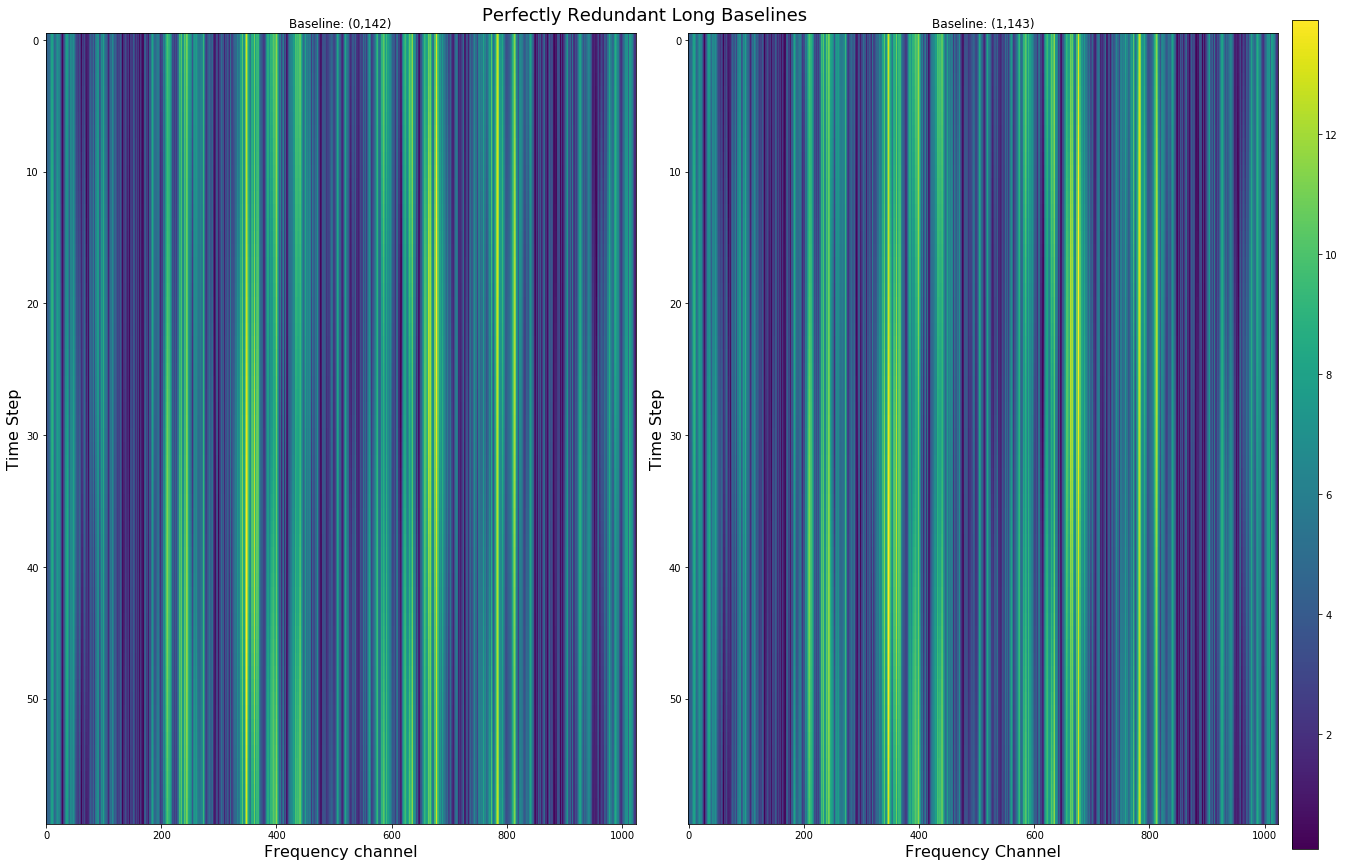

In [40]:

fig, axarr = plt.subplots(1,2, figsize=(18, 12))
plt.suptitle('Perfectly Redundant Long Baselines', y=1, fontsize=18)

axarr[0].set_title('Baseline: (0,142)')
axarr[0].set_ylabel('Time Step', fontsize=16)
axarr[0].set_xlabel('Frequency channel', fontsize=16)
axarr[0].imshow(np.abs(v.get_data(0,142,'xx')),aspect='auto')

axarr[1].set_title('Baseline: (1,143)')
axarr[1].set_ylabel('Time Step', fontsize=16)
axarr[1].set_xlabel('Frequency Channel', fontsize=16)
im=axarr[1].imshow(np.abs(v.get_data(1,143,'xx')),aspect='auto')

cb_ax = fig.add_axes([1, .025, 0.02, .96])
cbar = fig.colorbar(im, cax=cb_ax)

plt.tight_layout()
plt.show()


## Real vs. Simulated Data

In [17]:

v_mod = deepcopy(uv)

test = v_mod.data_array


In [18]:

for i in range(uv.data_array.shape[0]):
    
    for j in range(uv.data_array.shape[3]):
        
        test[i,0,62,j] = (test[i,0,60,j]+test[i,0,63,j])/2.
        test[i,0,61,j] = (test[i,0,60,j]+test[i,0,63,j])/2.

        test[i,0,379,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,380,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,381,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,382,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,383,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,384,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,385,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        
        test[i,0,138,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,139,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,140,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,141,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,142,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,143,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,144,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,145,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,146,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,147,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,148,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,149,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,150,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,151,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,152,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,153,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,154,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        
        test[i,0,1023,j] = test[i,0,1022,j]


In [19]:

data = v_mod.get_data(0,143,'xx')

data_real = medfilt2d(np.abs(data),(5,5))


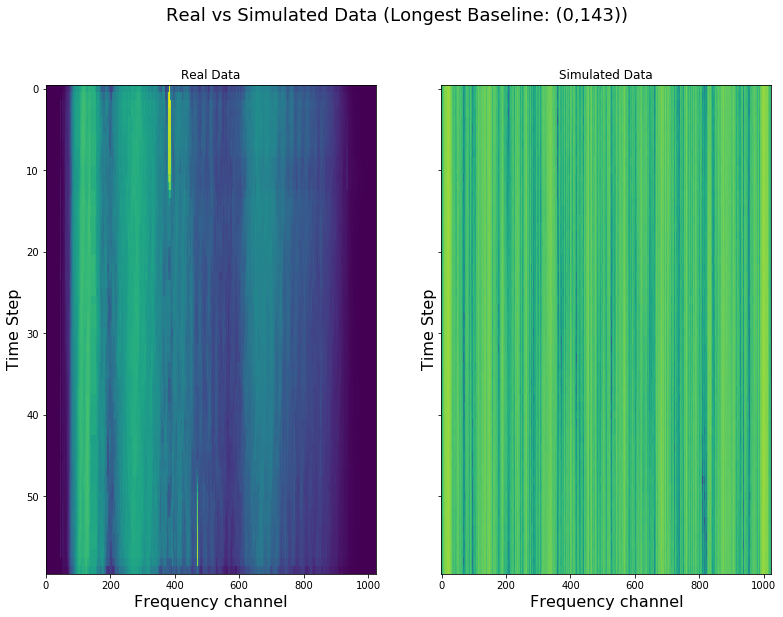

In [20]:
ant_1 = 0
ant_2 = 143

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize =(13,9))
data_sim = v.get_data(ant_1,ant_2,'xx')

plt.suptitle('Real vs Simulated Data (Longest Baseline: (0,143))', y=1, fontsize=18)

ax1.imshow(np.abs(data_real), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
ax1.set_title('Real Data')
ax1.set_ylabel('Time Step', fontsize=16)
ax1.set_xlabel('Frequency channel', fontsize=16)

ax2.imshow(np.abs(data_sim), aspect='auto', norm=SymLogNorm(vmin=0,vmax=150,linthresh=.1))
ax2.set_title('Simulated Data')
ax2.set_ylabel('Time Step', fontsize=16)
ax2.set_xlabel('Frequency channel', fontsize=16)
plt.show()


# Non-Redundant Signal Simulation

In [46]:

new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

s_width = 1

s_amp = 0

i_width = 1

i_amp = 0

n_width = 0

n_amp = 0

for i in reds:
        
    sig = signal(s_amp,s_width,i[0])
    
    print 'working'
        
    for j in i:
        
        i_sig = signal(i_amp,i_width,j)
            
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2)
            
        ratio = np.sqrt(norm_power/new_power)
            
        sigs = (sig + i_sig) * ratio
            
        indices = v.antpair2ind(j[0],j[1])
            
        noi = noise(n_amp,n_width)
        
        visibility = sigs + noi
            
        new_data_array[indices,0,:,:] = visibility
        

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [47]:

for i in nonreds:
    
    print 'working'
    
    sig = signal(s_amp,s_width,i)
    
    i_sig = signal(i_amp,i_width,i)
    
    indices = v.antpair2ind(i[0],i[1])
            
    noi = noise(n_amp,n_width)
        
    norm_power = float(s_width**2)
            
    new_power = float(norm_power + i_width**2)
            
    ratio = np.sqrt(norm_power/new_power)        
        
    sigs = (sig + i_sig) * ratio
            
    visibility = sigs + noi
            
    new_data_array[indices,0,:,:] = visibility
    

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [48]:
v.data_array = new_data_array

## Short Baselines

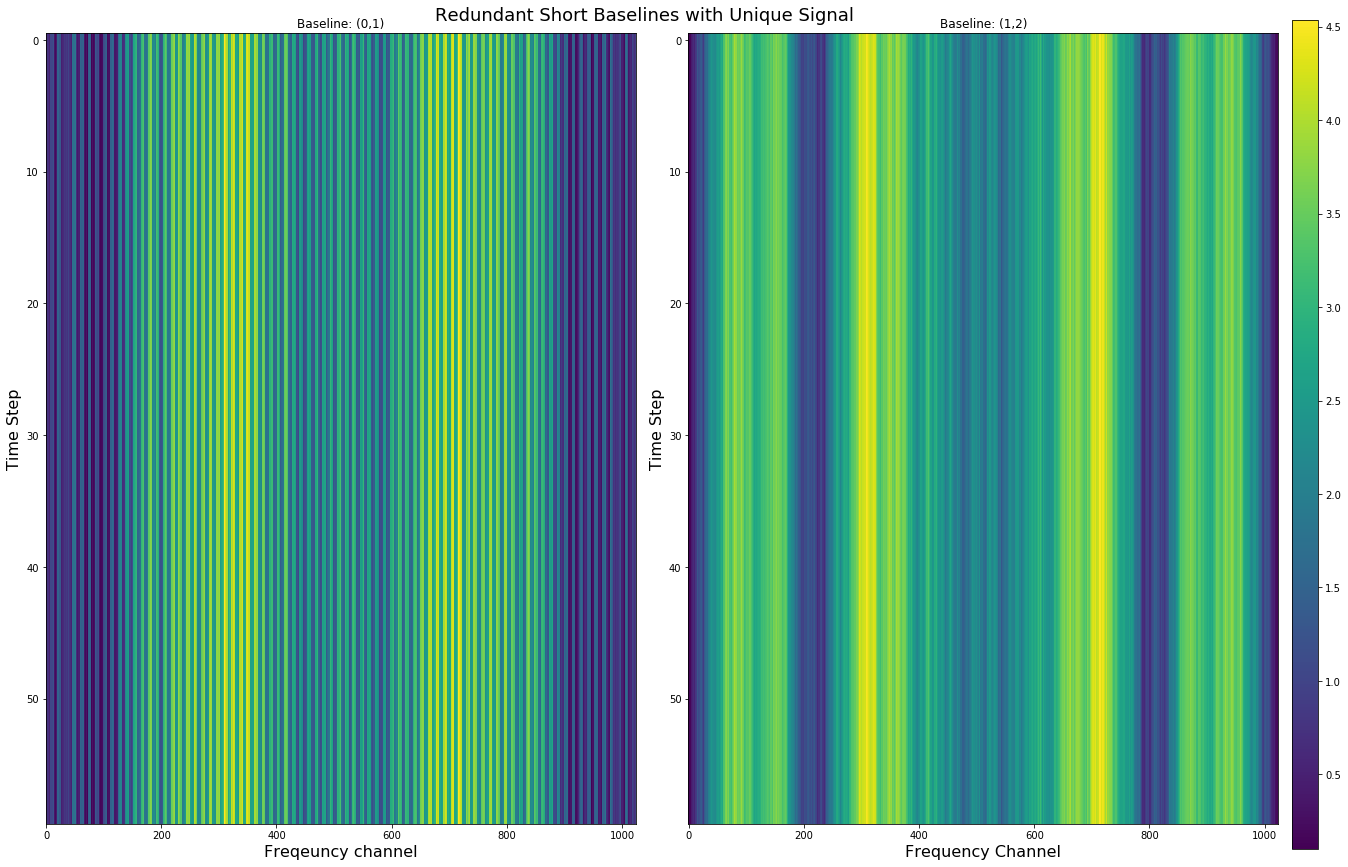

In [49]:

fig, axarr = plt.subplots(1,2, figsize=(18, 12))
plt.suptitle('Redundant Short Baselines with Unique Signal', y=1, fontsize=18)

axarr[0].set_title('Baseline: (0,1)')
axarr[0].set_ylabel('Time Step', fontsize=16)
axarr[0].set_xlabel('Freqeuncy channel', fontsize=16)
axarr[0].imshow(np.abs(v.get_data(0,1,'xx')),aspect='auto')

axarr[1].set_title('Baseline: (1,2)')
axarr[1].set_ylabel('Time Step', fontsize=16)
axarr[1].set_xlabel('Frequency Channel', fontsize=16)
im=axarr[1].imshow(np.abs(v.get_data(1,2,'xx')),aspect='auto')

cb_ax = fig.add_axes([1, .025, 0.02, .96])
cbar = fig.colorbar(im, cax=cb_ax)

plt.tight_layout()
plt.show()


## Long Baselines

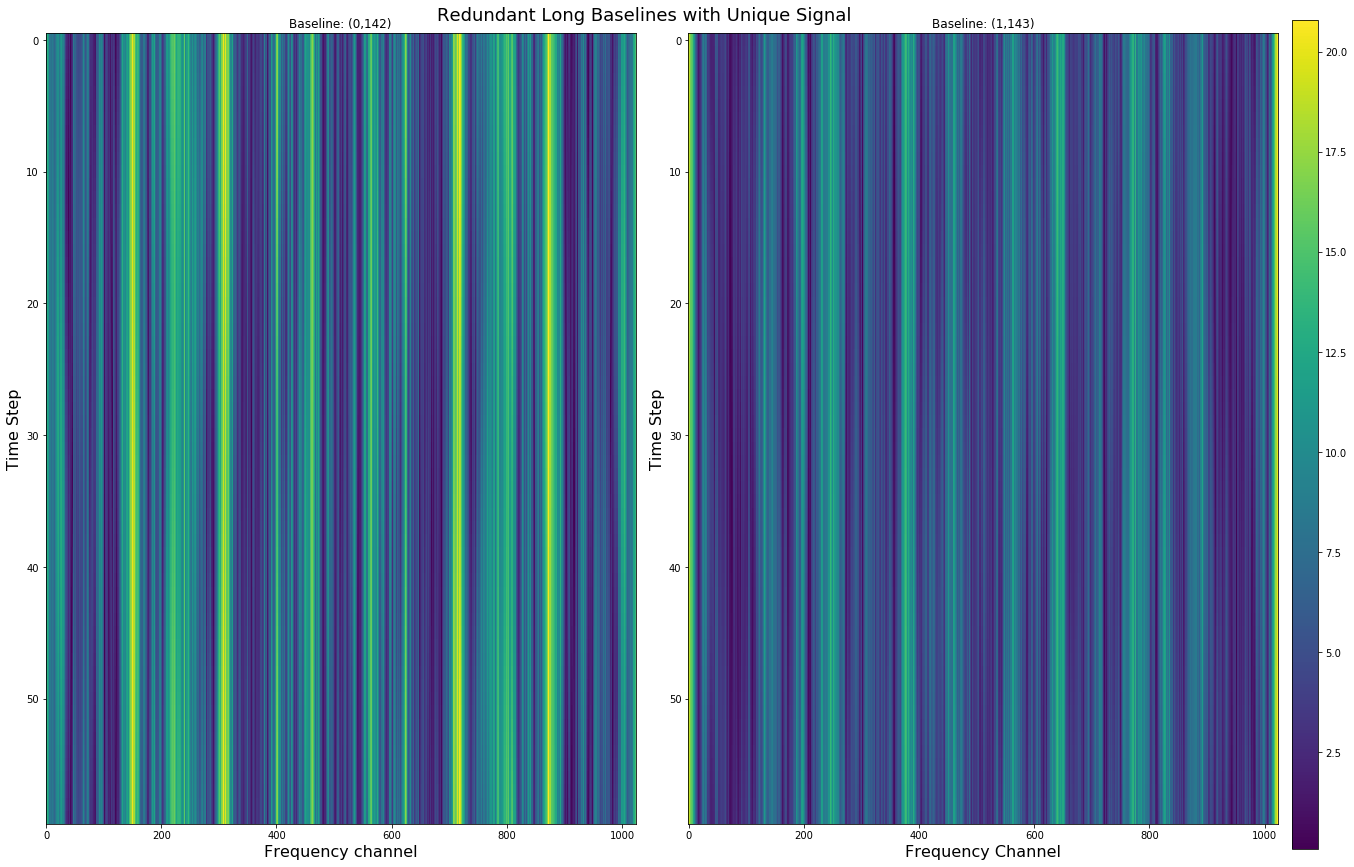

In [50]:

fig, axarr = plt.subplots(1,2, figsize=(18, 12))
plt.suptitle('Redundant Long Baselines with Unique Signal', y=1, fontsize=18)

axarr[0].set_title('Baseline: (0,142)')
axarr[0].set_ylabel('Time Step', fontsize=16)
axarr[0].set_xlabel('Frequency channel', fontsize=16)
axarr[0].imshow(np.abs(v.get_data(0,142,'xx')),aspect='auto')

axarr[1].set_title('Baseline: (1,143)')
axarr[1].set_ylabel('Time Step', fontsize=16)
axarr[1].set_xlabel('Frequency Channel', fontsize=16)
im=axarr[1].imshow(np.abs(v.get_data(1,143,'xx')),aspect='auto')

cb_ax = fig.add_axes([1, .025, 0.02, .96])
cbar = fig.colorbar(im, cax=cb_ax)

plt.tight_layout()
plt.show()

## Redundancy Correlation Metrics

In [26]:
am.data.data_array = new_data_array

In [27]:
am.xants = []

In [28]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)

In [29]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


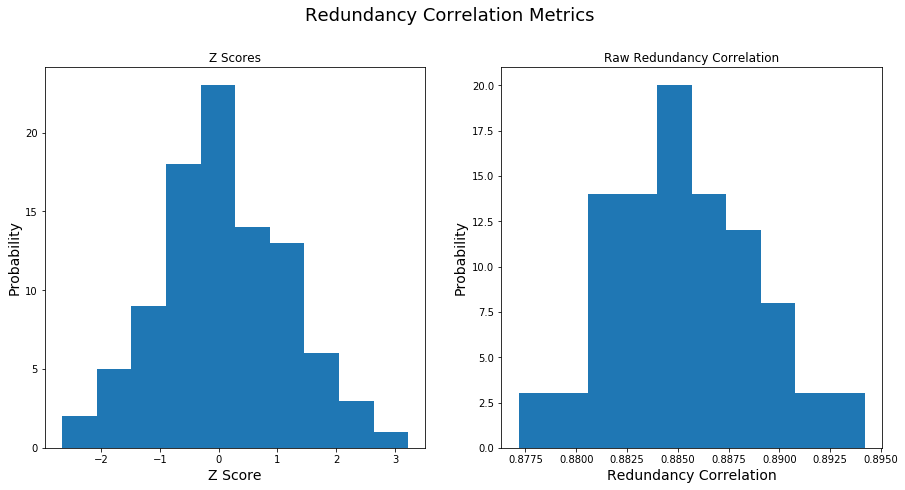

In [30]:

fig, axarr = plt.subplots(1,2, figsize=(15, 7))

plt.suptitle('Redundancy Correlation Metrics', y=1, fontsize=18)

ax1.hist(values)
axarr[0].hist(values)
axarr[0].set_title('Z Scores')
axarr[0].set_ylabel('Probability', fontsize=14)
axarr[0].set_xlabel('Z Score', fontsize=14)

axarr[1].hist(values_raw)
axarr[1].set_title('Raw Redundancy Correlation')
axarr[1].set_ylabel('Probability', fontsize=14)
axarr[1].set_xlabel('Redundancy Correlation', fontsize=14)

plt.show()


In [21]:
print reds[5]

for j in reds[5]:
    
    ant_1 = j[0]
    
    ant_2 = j[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    print dist
    

[(0, 1), (1, 2), (11, 12), (12, 13), (13, 14), (23, 24), (24, 25), (25, 26), (26, 27), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (120, 121), (121, 122), (122, 123), (123, 124), (141, 142), (142, 143)]
14.607952464
14.6079522253
14.6081164532
14.6080715916
14.608619102
14.6079623194
14.6079518459
14.6079516075
14.6082903485
14.6082256693
14.6079517252
14.6079788471
14.6079615037
14.608070774
14.6079515215
14.6081156913
14.6079786112
14.60795099
14.6079781341
14.6079514011
14.6079614192
14.6079782612
14.6079609192
14.6079778765
14.6083611679
14.6079783783
14.6079473232
14.6079505189
14.6079468702
14.607960368
14.6081142799
14.6079465132
14.6079600121
14.6079598419
14.6079459588
14.6079493261
14.6079457005
